### Definition of popular

- share count
- like count
- comment count
- the rate of all 3 above with respect to play count

### Hypothesis: Length of videos (coupled with music and content) explains popularity of TikTok

Given people's short attention span, TikTok's built-in video recording feature is capped at 15s to encourage users to be more creative in grabbing attention through content
(i.e. catchy music, duet, challenges etc.)

There are methods to upload > 15s and > 60s but with the following video limitations:
- File Size: Videos can be up to 287 MB for iOS devices and 72 MB for Android. Ads can be up to 500 MB.
- Orientation: TikTok is designed for showcasing vertical video, but you can change it to horizontal if you want.
- Dimensions: TikTok can handle up to standard HD dimensions (1080 x 1920)
- Aspect Ratio: TikTok videos are normally formatted in standard smartphone aspect ratio (9:16). You can also make 1:1 videos but these are less common and won’t fir the entire screen.
- File type: User can upload .mp4 and .mov file types. Ads support .avi and .gif files

## Import Packages

In [ ]:
import json
import numpy as np
import pandas as pd
from clean import CleanData
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from datetime import datetime, timedelta

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.options.mode.chained_assignment = None

## Read Data

In [ ]:
data = json.load(open('./data/trending.json', encoding="utf8"))
data = data['collector']
toParse = pd.json_normalize(data)
df = CleanData(toParse)
df.process_the_data()
df.summary_of_data()

Missing Data:
None

Data Time Period:
Start Date: 2020-09-22 14:22:38
  End Date: 2020-12-21 03:18:36
 Timedelta: 89 days 12:55:58


## Segementation

In [ ]:
df_clean = df.dfm
# df_clean.sort_values(by=['likeCount'],ascending=False).head(1).T
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 35 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   id                       1000 non-null   object        
 1   text                     1000 non-null   object        
 2   createTime               1000 non-null   datetime64[ns]
 3   webVideoUrl              1000 non-null   object        
 4   likeCount                1000 non-null   int64         
 5   shareCount               1000 non-null   int64         
 6   playCount                1000 non-null   int64         
 7   commentCount             1000 non-null   int64         
 8   downloaded               1000 non-null   bool          
 9   mentions                 1000 non-null   object        
 10  hashtags                 1000 non-null   object        
 11  authorMeta.id            1000 non-null   object        
 12  authorMeta.secUid        1000 non-n

In [ ]:
segmentDf = df_clean[['authorMeta.name','authorMeta.verified','shareRate','likeRate','commentRate','playCount','shareCount','likeCount','commentCount']]
segmentDf = segmentDf.groupby(['authorMeta.name','authorMeta.verified'],as_index=False).agg(np.mean)
segmentDf = segmentDf.sort_values(by='likeRate',ascending=False)#.head(3).T
segmentDf.head(3).T

,57,399,595
authorMeta.name,anwarali0125,l3fty_fr3ak,reus.fx
authorMeta.verified,False,False,False
shareRate,0.003181,0.020488,0.017623
likeRate,0.485684,0.446655,0.375128
commentRate,0.008484,0.011573,0.007987
playCount,943.0,55300.0,232950.0
shareCount,3.0,1133.0,4390.0
likeCount,458.0,24700.0,87850.0
commentCount,8.0,640.0,1832.0


In [ ]:
segmentDf['authorMeta.verified'].unique()

array([False,  True])

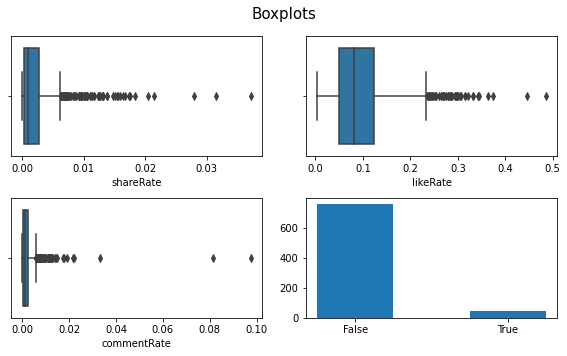

In [ ]:
fig = plt.figure(figsize=(8, 5), tight_layout=True)
plt.suptitle('Boxplots', fontsize=15)
fig.add_subplot(221)
sns.boxplot(x='shareRate', data=segmentDf)
fig.add_subplot(222)
sns.boxplot(x='likeRate', data=segmentDf)
fig.add_subplot(223)
sns.boxplot(x='commentRate', data=segmentDf)
ax = fig.add_subplot(224)

categories = segmentDf['authorMeta.verified'].unique()
counts = segmentDf['authorMeta.verified'].value_counts()
pos = [0,1]
ax.bar(pos,counts,width=0.5)

ax.set_xticks(pos)
ax.set_xticklabels(categories)

plt.show()

## EDA

### Old - Plot distribution of video creation between data time period

In [ ]:
df_clean[['createTime']].groupby(df_clean["createTime"].dt.month).count().transpose()

createTime,9,10,11,12
createTime,80,325,311,284


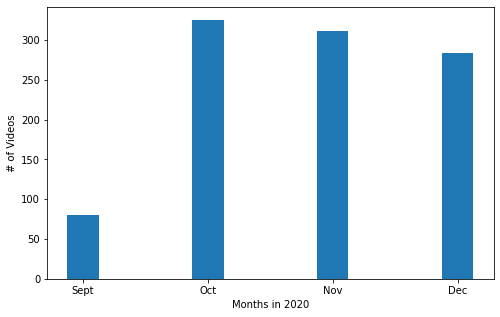

In [ ]:
pivot_df = df_clean[['createTime']].groupby(df_clean["createTime"].dt.month).count()#.sort_values(by='videoMeta.duration',axis=1)#.plot(kind="bar", legend=False)
pivot_df = pivot_df.rename(columns={"createTime": "count"})
pivot_df = pivot_df.reset_index()

fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(111)
x = pivot_df['createTime']
y = pivot_df['count']

ax.bar(x,y,width=0.25)
ax.set_xticks(np.arange(min(x), max(x)+1, 1))
ax.set_xticklabels(['Sept','Oct','Nov','Dec'])
ax.set_xlabel('Months in 2020')
ax.set_ylabel('# of Videos')
plt.show()

### Old - Plot distribution of video lengths

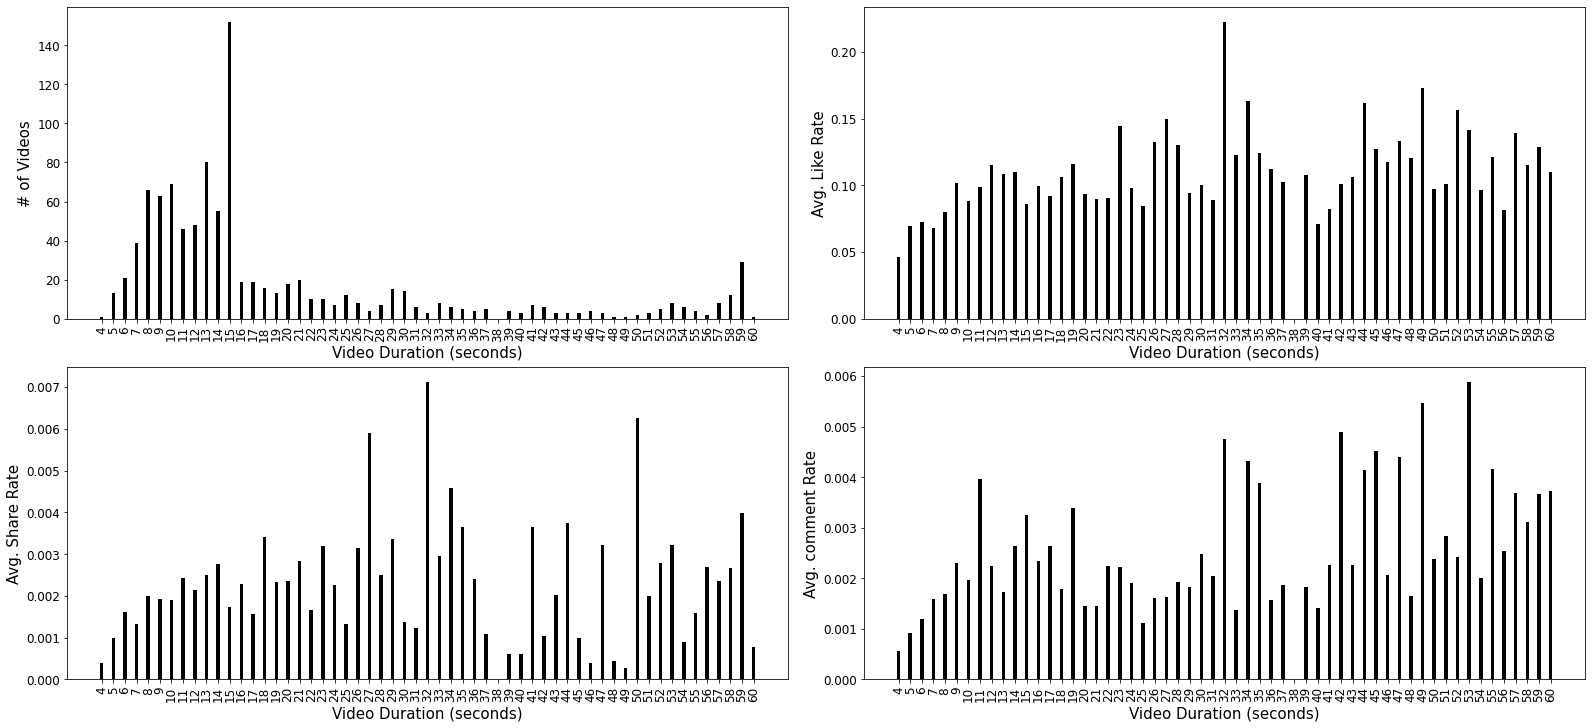

In [10]:
count_df = df_clean[['videoMeta.duration']].groupby(df_clean["videoMeta.duration"]).count()#.sort_values(by='videoMeta.duration',axis=1)#.plot(kind="bar", legend=False)
count_df = count_df.rename(columns={"videoMeta.duration": "count"})
count_df = count_df.reset_index()

avg_df = df_clean[['videoMeta.duration','likeRate','shareRate','commentRate']]
avg_df = avg_df.groupby(['videoMeta.duration'],as_index=False).agg([np.mean]).reset_index()
avg_df.columns = avg_df.columns.droplevel(-1)
# avg_df.sort_values(by='likeCount',ascending=False).head(3).T
# avg_df.head()

fig = plt.figure(figsize=(22,10),constrained_layout=True)
bar_width = 0.3

ax1 = fig.add_subplot(221)
x = count_df['videoMeta.duration']
y = count_df['count']

ax1.bar(x,y, color='k', width=bar_width)
ax1.set_xticks(np.arange(min(x), max(x)+1, 1))
ax1.set_xticklabels(ax1.get_xticks(),rotation=90)
ax1.set_xlabel('Video Duration (seconds)', fontdict={'fontsize': 15})
ax1.set_ylabel('# of Videos', fontdict={'fontsize': 15})
ax1.tick_params(axis='both', which='major', labelsize=12)

# ax1.bar([15], count_df[count_df['videoMeta.duration'] == 15]['count'].iloc[0], color='r', width=bar_width)

ax2 = fig.add_subplot(222)
x = avg_df['videoMeta.duration']
y = avg_df['likeRate']

ax2.bar(x,y,color='k', width=bar_width)
ax2.set_xticks(np.arange(min(x), max(x)+1, 1))
ax2.set_xticklabels(ax2.get_xticks(),rotation=90)
ax2.set_xlabel('Video Duration (seconds)', fontdict={'fontsize': 15})
ax2.set_ylabel('Avg. Like Rate', fontdict={'fontsize': 15})
ax2.tick_params(axis='both', which='major', labelsize=12)

# target = [9,40]
# ax2.bar(target, avg_df[avg_df['videoMeta.duration'].isin(target)]['likeRate'], color='r', width=bar_width)

ax3 = fig.add_subplot(223)
x = avg_df['videoMeta.duration']
y = avg_df['shareRate']

ax3.bar(x,y,color='k', width=bar_width)
ax3.set_xticks(np.arange(min(x), max(x)+1, 1))
ax3.set_xticklabels(ax3.get_xticks(),rotation=90)
ax3.set_xlabel('Video Duration (seconds)', fontdict={'fontsize': 15})
ax3.set_ylabel('Avg. Share Rate', fontdict={'fontsize': 15})
ax3.tick_params(axis='both', which='major', labelsize=12)

# target = [36,40]
# ax3.bar(target, avg_df[avg_df['videoMeta.duration'].isin(target)]['shareRate'], color='r', width=bar_width)

ax4 = fig.add_subplot(224)
x = avg_df['videoMeta.duration']
y = avg_df['commentRate']

ax4.bar(x,y,color='k', width=bar_width)
ax4.set_xticks(np.arange(min(x), max(x)+1, 1))
ax4.set_xticklabels(ax4.get_xticks(),rotation=90)
ax4.set_xlabel('Video Duration (seconds)', fontdict={'fontsize': 15})
ax4.set_ylabel('Avg. comment Rate', fontdict={'fontsize': 15})
ax4.tick_params(axis='both', which='major', labelsize=12)

# target = [9]
# ax4.bar(target, avg_df[avg_df['videoMeta.duration'].isin(target)]['commentRate'], color='r', width=bar_width)

plt.show()

### Filter and aggregate data

In [11]:
filter_df = df_clean[['createTime','videoMeta.duration','authorMeta.verified','shareCount','likeCount','commentCount','playCount','shareRate','likeRate','commentRate']]
filter_df['videoMeta.duration_segment'] = filter_df['videoMeta.duration'].apply(lambda x: '<= 15' if x <= 15 else '> 15 and <= 30' if x > 15 and x <= 30 else '> 30 and <= 45' if x > 30 and x <= 45 else '> 45 and <= 60' if x > 45 and x <= 60 else '> 60') 
filter_df['date'] = filter_df['createTime'].dt.date
filter_df.drop(['createTime'],axis=1,inplace=True)
filter_df.head()


,videoMeta.duration,authorMeta.verified,shareCount,likeCount,commentCount,playCount,shareRate,likeRate,commentRate,videoMeta.duration_segment,date
0,15,False,50,3710,68,44800,0.001116,0.082812,0.001518,<= 15,2020-12-17
1,11,False,1817,55700,936,838100,0.002168,0.066460,0.001117,<= 15,2020-09-23
2,19,False,21100,936200,27100,15300000,0.001379,0.061190,0.001771,> 15 and <= 30,2020-11-24
3,13,False,197,12900,143,94900,0.002076,0.135933,0.001507,<= 15,2020-12-05
4,22,False,198,8805,52,115300,0.001717,0.076366,0.000451,> 15 and <= 30,2020-12-13


In [12]:
# segment_type = 'with date'
# segment_type = 'without date'
segment_type = 'video length and verified status'

if segment_type == 'video length groups':
    count_df = filter_df.drop(['authorMeta.verified','shareRate','likeRate','commentRate'],axis=1,inplace=False)
    count_df = count_df.groupby(['videoMeta.duration_segment']).count()#.sort_values(by='videoMeta.duration',axis=1)#.plot(kind="bar", legend=False)
    count_df = count_df.rename(columns={"videoMeta.duration": "numVideos"})
    count_df = count_df.reset_index()

    avg_df = filter_df.groupby(['videoMeta.duration_segment'],as_index=False)['shareRate','likeRate','commentRate'].agg([np.mean]).reset_index()
    avg_df.columns = avg_df.columns.droplevel(-1)
    # avg_df.sort_values(by='likeCount',ascending=False).head(3).T
    avg_df = avg_df.merge(count_df,on=['videoMeta.duration_segment'],how='left')

elif segment_type == 'time series':
    count_df = filter_df.drop(['authorMeta.verified','shareRate','likeRate','commentRate'],axis=1,inplace=False)
    count_df = count_df.groupby(['date','videoMeta.duration_segment']).count()#.sort_values(by='videoMeta.duration',axis=1)#.plot(kind="bar", legend=False)
    count_df = count_df.rename(columns={"videoMeta.duration": "numVideos"})
    count_df = count_df.reset_index()

    avg_df = filter_df.groupby(['date','videoMeta.duration_segment'],as_index=False)['shareRate','likeRate','commentRate'].agg([np.mean]).reset_index()
    avg_df.columns = avg_df.columns.droplevel(-1)
    # avg_df.sort_values(by='likeCount',ascending=False).head(3).T
    avg_df = avg_df.merge(count_df,on=['date','videoMeta.duration_segment'],how='left')

elif segment_type == 'video length and verified status':
    count_df = filter_df[['videoMeta.duration','shareRate','authorMeta.verified']]
    count_df = count_df.groupby(['videoMeta.duration','authorMeta.verified']).count()#.sort_values(by='videoMeta.duration',axis=1)#.plot(kind="bar", legend=False)
    count_df = count_df.rename(columns={"shareRate": "numVideos"})
    count_df = count_df.reset_index()

    avg_df = filter_df.groupby(['videoMeta.duration','authorMeta.verified'],as_index=False)['shareCount','likeCount','commentCount','playCount','shareRate','likeRate','commentRate'].agg([np.mean]).reset_index()
    avg_df.columns = avg_df.columns.droplevel(-1)
    # avg_df.sort_values(by='likeCount',ascending=False).head(3).T
    avg_df = avg_df.merge(count_df,on=['videoMeta.duration','authorMeta.verified'],how='left')
    
avg_df.head()

/tmp/ipykernel_6104/107332682.py:33: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  avg_df = filter_df.groupby(['videoMeta.duration','authorMeta.verified'],as_index=False)['shareCount','likeCount','commentCount','playCount','shareRate','likeRate','commentRate'].agg([np.mean]).reset_index()


,videoMeta.duration,authorMeta.verified,shareCount,likeCount,commentCount,playCount,shareRate,likeRate,commentRate,numVideos
0,4,False,19.000000,2232.00,27.00,47900.00,0.000397,0.046597,0.000564,1
1,5,False,1196.583333,28763.00,409.75,353850.00,0.001060,0.067709,0.000917,12
2,5,True,14.000000,13800.00,142.00,155000.00,0.000090,0.089032,0.000916,1
3,6,False,430.050000,9018.65,113.60,138271.85,0.001650,0.072396,0.001242,20
4,6,True,1762.000000,171500.00,1051.00,2400000.00,0.000734,0.071458,0.000438,1


### Plot Time Series

KeyError: 'date'

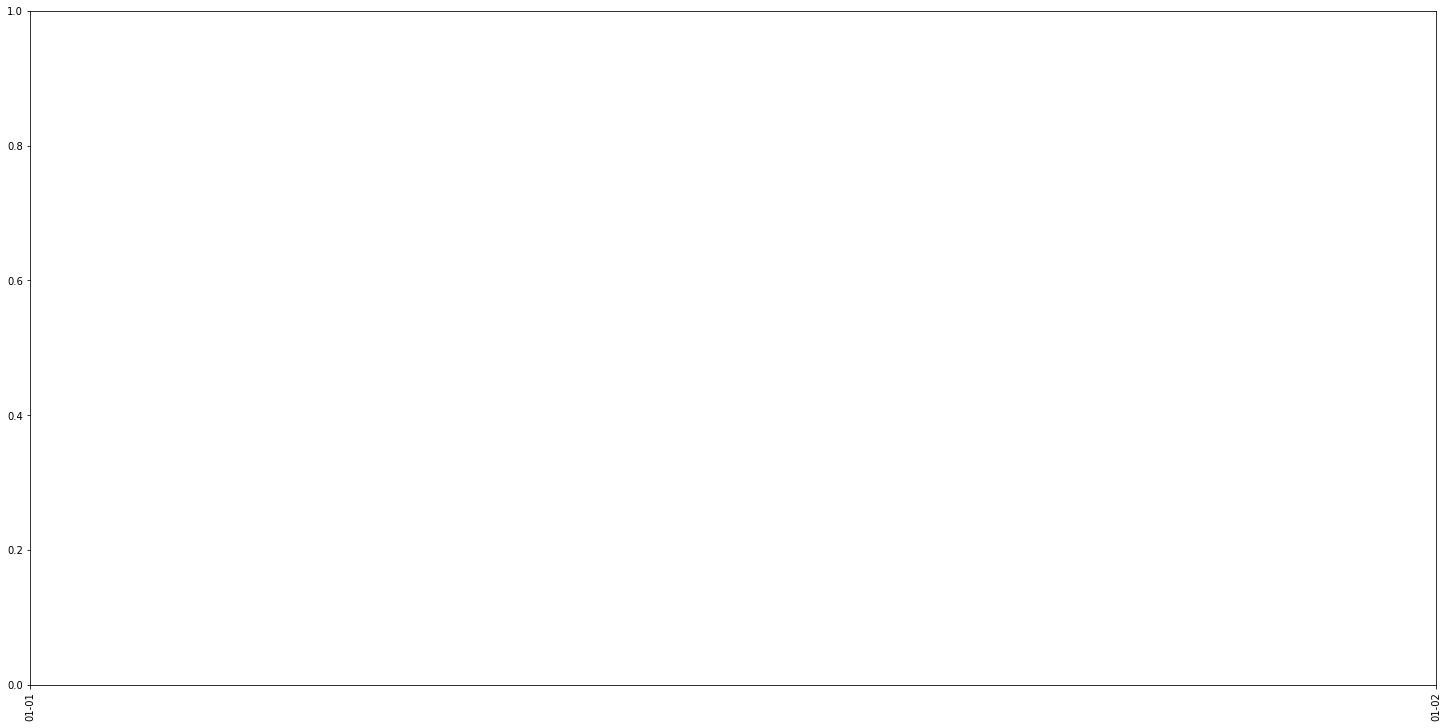

In [13]:
def plot_scatter(ax, x, y, color, edgecolors):
    ax.scatter(x,y, color=color,edgecolors=edgecolors,linewidths=0.5,s=100)
    # ax.set_xlabel(x_label, fontdict={'fontsize': 15})
    # ax.set_ylabel(y_label, fontdict={'fontsize': 15})
    # ax.set_title(title, fontdict={'fontsize': 15})

fig = plt.figure(figsize=(20,10),constrained_layout=True)

ax1 = fig.add_subplot(111)
ax1.xaxis.set_major_locator(mdates.DayLocator(interval=1))
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
ax1.xaxis.set_tick_params(rotation=90)
ax1.set_xlim([min(avg_df['date'])  - timedelta(days=1), max(avg_df['date'])])
ax1.set_ylim([0,avg_df['shareRate'].max()+0.0025])

segment_1 = avg_df[avg_df['videoMeta.duration_segment'] == '<= 15']
plot_scatter(ax1, segment_1['date'], segment_1['shareRate'], color='blue', edgecolors='b')

segment_2 = avg_df[avg_df['videoMeta.duration_segment'] == '> 15 and <= 30']
plot_scatter(ax1, segment_2['date'], segment_2['shareRate'], color='yellow', edgecolors='b')

segment_3 = avg_df[avg_df['videoMeta.duration_segment'] == '> 30 and <= 45']
plot_scatter(ax1, segment_3['date'], segment_3['shareRate'], color='green', edgecolors='b')

segment_4 = avg_df[avg_df['videoMeta.duration_segment'] == '> 45 and <= 60']
plot_scatter(ax1, segment_4['date'], segment_4['shareRate'], color='red', edgecolors='b')

ax1.tick_params(axis='both', which='major', labelsize=12)
# ax1.legend(handles, labels, loc="upper right", title="Sizes")

plt.show()

### Plot y = share rate, x = video length, z = verified

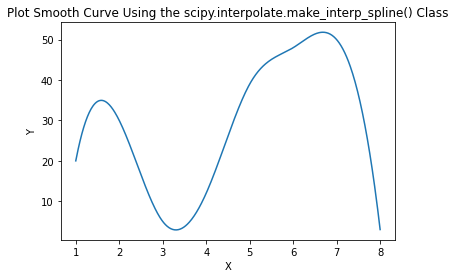

In [ ]:
import numpy as np
from scipy.interpolate import make_interp_spline
import matplotlib.pyplot as plt
 
# Dataset
x = np.array([1, 2, 3, 4, 5, 6, 7, 8])
y = np.array([20, 30, 5, 12, 39, 48, 50, 3])
 
X_Y_Spline = make_interp_spline(x, y)
X_ = np.linspace(x.min(), x.max(), 500)
Y_ = X_Y_Spline(X_)
 
# Plotting the Graph
plt.plot(X_, Y_)
plt.title("Plot Smooth Curve Using the scipy.interpolate.make_interp_spline() Class")
plt.xlabel("X")
plt.ylabel("Y")
plt.show()

In [ ]:
def plot_line(ax1, response, response_label, edgecolors, area_color1, area_color2, alpha, legend=False, spines=False, xaxis=False):
    x = avg_df['videoMeta.duration']
    y = avg_df[response]
    ax1.set_xticks(np.arange(min(x), max(x)+1, 1))
    ax1.set_xticklabels([''] * len(np.arange(min(x), max(x)+1, 1)))
    # ax1.set_xticklabels(ax1.get_xticks(),rotation=90)
    # ax1.set_yticks(np.arange(0, max(y)+0.0005, 0.001))
    ax1.set_ylim([min(y),max(y)+0.001])

    x = avg_df[avg_df['authorMeta.verified'] == False]['videoMeta.duration']
    y = avg_df[avg_df['authorMeta.verified'] == False][response]

    # X_Y_Spline = make_interp_spline(x, y)
    # X_ = np.linspace(x.min(), x.max(), 500)
    # Y_ = X_Y_Spline(X_)

    ax1.plot(x,y,color=edgecolors,linewidth=1.5, label='Unverified')
    l1 = ax1.fill_between(x,y, color=area_color1,alpha=alpha)

    x = avg_df[avg_df['authorMeta.verified'] == True]['videoMeta.duration']
    y = avg_df[avg_df['authorMeta.verified'] == True][response]

    # X_Y_Spline = make_interp_spline(x, y)
    # X_ = np.linspace(x.min(), x.max(), 500)
    # Y_ = X_Y_Spline(X_)

    ax1.plot(x,y,color=edgecolors,linewidth=1.5, label='Verified')
    l2 = ax1.fill_between(x,y,color=area_color2,alpha=alpha)    
    
    if legend == True:
        ax1.legend(handles=[l1,l2], labels=['Not Verified','Verified'], edgecolor='black')

    # ax1.set_xlabel('Video Duration (seconds)', fontdict={'fontsize': 20})
    ax1.set_ylabel(f'{response_label}', fontdict={'fontsize': 14})
    # ax1.set_title(f'Distribution of {response_label}', fontdict={'fontsize': 25})
    
    if spines == True:
        ax1.spines['right'].set_visible(False)
        ax1.spines['top'].set_visible(False)
    
    if xaxis == True:
        ax1.spines['bottom'].set_visible(False)

    ax1.tick_params(axis='both', which='major', labelsize=12.5)

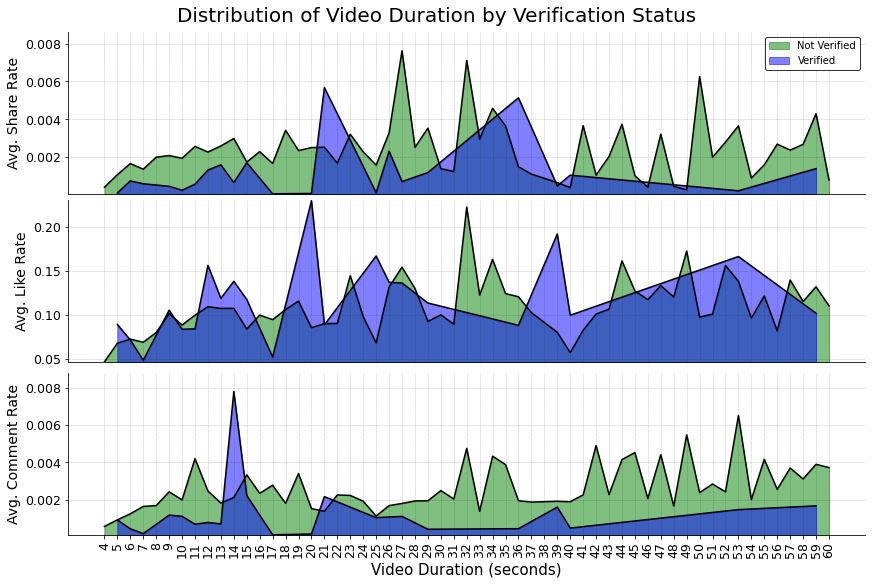

In [ ]:
fig = plt.figure(figsize=(12,8),constrained_layout=True)
fig.suptitle('Distribution of Video Duration by Verification Status', fontsize=20)

ax1 = fig.add_subplot(311)
plot_line(ax1, 'shareRate', 'Avg. Share Rate', 'k', 'g', 'b', 0.5, legend=True, spines=True)
ax1.tick_params(axis='x',which='both',bottom=False,top=False,labelbottom=False)
ax1.grid(color = 'k', linestyle = '--', linewidth = 0.5,alpha=0.25)

ax2 = fig.add_subplot(312)
plot_line(ax2, 'likeRate', 'Avg. Like Rate', 'k', 'g', 'b', 0.5, spines=True)
ax2.tick_params(axis='x',which='both',bottom=False,top=False,labelbottom=False)
ax2.grid(color = 'k', linestyle = '--', linewidth = 0.5,alpha=0.25)

ax3 = fig.add_subplot(313)
plot_line(ax3, 'commentRate', 'Avg. Comment Rate', 'k', 'g', 'b', 0.5, spines=True)
# ax3.tick_params(axis='x',which='both',bottom=False,top=False,labelbottom=False)
ax3.set_xticklabels(ax3.get_xticks(),rotation=90)
ax3.set_xlabel('Video Duration (seconds)', fontdict={'fontsize': 15})
ax3.grid(color = 'k', linestyle = '--', linewidth = 0.5,alpha=0.25)

# ax4 = fig.add_subplot(414)
# plot_line(ax4, 'numVideos', '# of Videos', 'k', 'g', 'b', 0.5)
# # ax4.set_xlabel('Video Duration (seconds)', fontdict={'fontsize': 20})
# ax4.set_xticklabels(ax4.get_xticks(),rotation=90)

# ax5 = fig.add_subplot(425)
# plot_line(ax5, 'shareCount', 'Avg. Share Count', 'k', 'r', 'b')

# ax6 = fig.add_subplot(426)
# plot_line(ax6, 'likeCount', 'Avg. Like Count', 'k', 'r', 'b')

# ax7 = fig.add_subplot(427)
# plot_line(ax7, 'commentCount', 'Avg. Comment Count', 'k', 'r', 'b')

# ax8 = fig.add_subplot(428)
# plot_line(ax8, 'playCount', 'Avg. Play Count', 'k', 'r', 'b')

plt.show()

In [ ]:
def plot_polar(ax1, response, response_label, edgecolors, area_color1, area_color2, alpha, legend=False, spines=False, xaxis=False):
    x = avg_df['videoMeta.duration']
    y = avg_df[response]
    ax1.set_xticks(np.arange(min(x), max(x)+1, 1))
    ax1.set_xticklabels([''] * len(np.arange(min(x), max(x)+1, 1)))
    # ax1.set_xticklabels(ax1.get_xticks(),rotation=90)
    # ax1.set_yticks(np.arange(0, max(y)+0.0005, 0.001))
    ax1.set_ylim([min(y),max(y)+0.001])

    x = avg_df[avg_df['authorMeta.verified'] == False]['videoMeta.duration']
    y = avg_df[avg_df['authorMeta.verified'] == False][response]

    # X_Y_Spline = make_interp_spline(x, y)
    # X_ = np.linspace(x.min(), x.max(), 500)
    # Y_ = X_Y_Spline(X_)

    ax1.plot(x,y,color=edgecolors,linewidth=1.5, label='Unverified')
    l1 = ax1.fill_between(x,y, color=area_color1,alpha=alpha)

    x = avg_df[avg_df['authorMeta.verified'] == True]['videoMeta.duration']
    y = avg_df[avg_df['authorMeta.verified'] == True][response]

    # X_Y_Spline = make_interp_spline(x, y)
    # X_ = np.linspace(x.min(), x.max(), 500)
    # Y_ = X_Y_Spline(X_)

    ax1.plot(x,y,color=edgecolors,linewidth=1.5, label='Verified')
    l2 = ax1.fill_between(x,y,color=area_color2,alpha=alpha)    
    
    if legend == True:
        ax1.legend(handles=[l1,l2], labels=['Not Verified','Verified'], edgecolor='black')

    # ax1.set_xlabel('Video Duration (seconds)', fontdict={'fontsize': 20})
    ax1.set_ylabel(f'{response_label}', fontdict={'fontsize': 14})
    # ax1.set_title(f'Distribution of {response_label}', fontdict={'fontsize': 25})
    
    if spines == True:
        ax1.spines['right'].set_visible(False)
        ax1.spines['top'].set_visible(False)
    
    if xaxis == True:
        ax1.spines['bottom'].set_visible(False)

    ax1.tick_params(axis='both', which='major', labelsize=12.5)

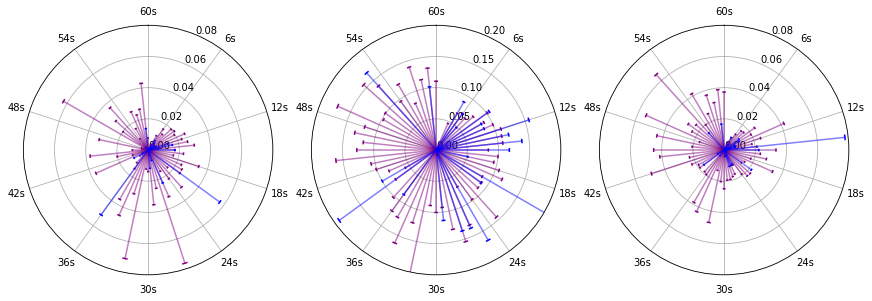

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
fig = plt.figure(figsize=(12,36),constrained_layout=True)

ax1= fig.add_subplot(131, projection='polar')
x = avg_df[avg_df['authorMeta.verified'] == False]['videoMeta.duration']
y = avg_df[avg_df['authorMeta.verified'] == False]["shareRate"]
ax1.set_theta_direction(-1)
ax1.set_xticks(np.arange(0,2*np.pi,np.pi/5))
ax1.set_xticklabels(["60s","6s","12s","18s","24s","30s","36s","42s","48s","54s"])
ax1.set_ylim(0,0.08)
ax1.yaxis.set_major_locator(plt.MultipleLocator(0.02))
ax1.set_theta_zero_location('N')
for _x,_y  in zip(x,y):
    # _x = _x + np.pi/30
    _x = _x*np.pi/30
    ax1.axvline(x=_x, ymin= 0,ymax =_y*125,alpha=0.5,color='purple')
    ax1.plot([_x-np.pi/180,_x,_x+np.pi/180],[_y*10,_y*10,_y*10],color='purple',linewidth=1.5) # draw the curve

x = avg_df[avg_df['authorMeta.verified'] == True]['videoMeta.duration']
y = avg_df[avg_df['authorMeta.verified'] == True]["shareRate"]
# ax1= plt.subplot(111, projection='polar')
# ax1.set_xticks(np.arange(0,2*np.pi,np.pi/5))
# ax1.set_xticklabels(["60s","6s","12s","18s","24s","30s","36s","42s","48s","54s"])
ax1.set_theta_zero_location('N')
for _x,_y  in zip(x,y):
    # _x = _x + np.pi/30
    _x = _x*np.pi/30
    ax1.axvline(x=_x, ymin= 0,ymax =_y*125,alpha=0.5,color='blue')
    ax1.plot([_x-np.pi/180,_x,_x+np.pi/180],[_y*10,_y*10,_y*10],color='blue',linewidth=1.5) # draw the curve

# ----------------------------------------------------------------------------------------------------------------------
ax2= fig.add_subplot(132, projection='polar')
x = avg_df[avg_df['authorMeta.verified'] == False]['videoMeta.duration']
y = avg_df[avg_df['authorMeta.verified'] == False]["likeRate"]
ax2.set_theta_direction(-1)
ax2.set_xticks(np.arange(0,2*np.pi,np.pi/5))
ax2.set_xticklabels(["60s","6s","12s","18s","24s","30s","36s","42s","48s","54s"])
ax2.set_ylim(0,0.2,0.05)
ax2.yaxis.set_major_locator(plt.MultipleLocator(0.05))
ax2.set_theta_zero_location('N')
for _x,_y  in zip(x,y):
    # _x = _x + np.pi/30
    _x = _x*np.pi/30
    ax2.axvline(x=_x, ymin= 0,ymax =_y*5,alpha=0.5,color='purple')
    ax2.plot([_x-np.pi/180,_x,_x+np.pi/180],[_y,_y,_y],color='purple',linewidth=1.5) # draw the curve

x = avg_df[avg_df['authorMeta.verified'] == True]['videoMeta.duration']
y = avg_df[avg_df['authorMeta.verified'] == True]["likeRate"]
# ax1= plt.subplot(111, projection='polar')
# ax1.set_xticks(np.arange(0,2*np.pi,np.pi/5))
# ax1.set_xticklabels(["60s","6s","12s","18s","24s","30s","36s","42s","48s","54s"])
ax1.set_theta_zero_location('N')
for _x,_y  in zip(x,y):
    # _x = _x + np.pi/30
    _x = _x*np.pi/30
    ax2.axvline(x=_x, ymin= 0,ymax =_y*5,alpha=0.5,color='blue')
    ax2.plot([_x-np.pi/180,_x,_x+np.pi/180],[_y,_y,_y],color='blue',linewidth=1.5) # draw the curve


# ----------------------------------------------------------------------------------------------------------------------
ax3= fig.add_subplot(133, projection='polar')
x = avg_df[avg_df['authorMeta.verified'] == False]['videoMeta.duration']
y = avg_df[avg_df['authorMeta.verified'] == False]["commentRate"]
ax3.set_theta_direction(-1)
ax3.set_xticks(np.arange(0,2*np.pi,np.pi/5))
ax3.set_xticklabels(["60s","6s","12s","18s","24s","30s","36s","42s","48s","54s"])
ax3.set_ylim(0,0.08)
ax3.yaxis.set_major_locator(plt.MultipleLocator(0.02))
ax3.set_theta_zero_location('N')
for _x,_y  in zip(x,y):
    # _x = _x + np.pi/30
    _x = _x*np.pi/30
    ax3.axvline(x=_x, ymin= 0,ymax =_y*125,alpha=0.5,color='purple')
    ax3.plot([_x-np.pi/180,_x,_x+np.pi/180],[_y*10,_y*10,_y*10],color='purple',linewidth=1.5) # draw the curve

x = avg_df[avg_df['authorMeta.verified'] == True]['videoMeta.duration']
y = avg_df[avg_df['authorMeta.verified'] == True]["commentRate"]
# ax1= plt.subplot(111, projection='polar')
# ax1.set_xticks(np.arange(0,2*np.pi,np.pi/5))
# ax1.set_xticklabels(["60s","6s","12s","18s","24s","30s","36s","42s","48s","54s"])
ax1.set_theta_zero_location('N')
for _x,_y  in zip(x,y):
    # _x = _x + np.pi/30
    _x = _x*np.pi/30
    ax3.axvline(x=_x, ymin= 0,ymax =_y*125,alpha=0.5,color='blue')
    ax3.plot([_x-np.pi/180,_x,_x+np.pi/180],[_y*10,_y*10,_y*10],color='blue',linewidth=1.5) # draw the curve

plt.show()

In [ ]:
def plot_line_2(ax1, response, response_label, edgecolors, area_color1, area_color2):
    x = avg_df['videoMeta.duration']
    y = avg_df[response]
    ax1.set_xticks(np.arange(min(x), max(x)+1, 1))
    ax1.set_xticklabels(ax1.get_xticks(),rotation=90)
    # ax1.set_yticks(np.arange(0, max(y)+0.0005, 0.001))
    ax1.set_ylim([min(y),max(y)+0.001])

    x = avg_df[avg_df['authorMeta.verified'] == False]['videoMeta.duration']
    y = avg_df[avg_df['authorMeta.verified'] == False][response]

    X_Y_Spline = make_interp_spline(x, y)
    X_ = np.linspace(x.min(), x.max(), 500)
    Y_ = X_Y_Spline(X_)

    ax1.plot(X_,Y_,color=edgecolors,linewidth=1.5, label='Unverified')
    ax1.fill_between(X_,Y_, color=area_color1,alpha=0.1)

    x = avg_df[avg_df['authorMeta.verified'] == True]['videoMeta.duration']
    y = avg_df[avg_df['authorMeta.verified'] == True][response]

    X_Y_Spline = make_interp_spline(x, y)
    X_ = np.linspace(x.min(), x.max(), 500)
    Y_ = X_Y_Spline(X_)

    ax1.plot(X_,Y_,color=edgecolors,linewidth=1.5, label='Verified')
    ax1.fill_between(X_,Y_,color=area_color2,alpha=0.1)

    ax1.set_xlabel('Video Duration (seconds)', fontdict={'fontsize': 20})
    ax1.set_ylabel(f'{response_label}', fontdict={'fontsize': 20})
    ax1.set_title(f'Distribution of {response_label}', fontdict={'fontsize': 25})

    ax1.tick_params(axis='both', which='major', labelsize=15)

# fig = plt.figure(figsize=(30,25),constrained_layout=True)
# ax1 = fig.add_subplot(421)
# plot_line_2(ax1, 'shareRate', 'Avg. Share Rate', 'k', 'r', 'b')

# ax2 = fig.add_subplot(422)
# plot_line_2(ax2, 'likeRate', 'Avg. Like Rate', 'k', 'r', 'b')

# ax3 = fig.add_subplot(423)
# plot_line_2(ax3, 'commentRate', 'Avg. Comment Rate', 'k', 'r', 'b')

# ax4 = fig.add_subplot(424)
# plot_line_2(ax4, 'numVideos', '# of Videos', 'k', 'r', 'b')

# ax5 = fig.add_subplot(425)
# plot_line_2(ax5, 'shareCount', 'Avg. Share Count', 'k', 'r', 'b')

# ax6 = fig.add_subplot(426)
# plot_line_2(ax6, 'likeCount', 'Avg. Like Count', 'k', 'r', 'b')

# ax7 = fig.add_subplot(427)
# plot_line_2(ax7, 'commentCount', 'Avg. Comment Count', 'k', 'r', 'b')

# ax8 = fig.add_subplot(428)
# plot_line_2(ax8, 'playCount', 'Avg. Play Count', 'k', 'r', 'b')

# plt.show()

,videoMeta.duration,authorMeta.verified,numVideos
0,4,False,1
1,5,False,12
2,5,True,1
3,6,False,20
4,6,True,1
5,7,False,38
6,7,True,1
7,8,False,66
8,9,False,57
9,9,True,6


NameError: name 'avg_df' is not defined

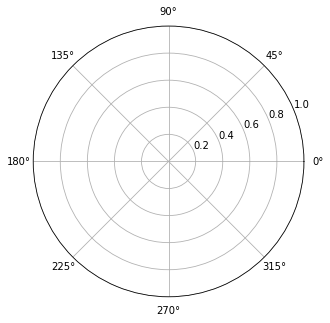

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
fig = plt.figure(figsize=(12,36),constrained_layout=True)

ax1= fig.add_subplot(131, projection='polar')
x = avg_df[avg_df['authorMeta.verified'] == False]['videoMeta.duration']
y = avg_df[avg_df['authorMeta.verified'] == False]["shareRate"]
ax1.set_theta_direction(-1)
ax1.set_xticks(np.arange(0,2*np.pi,np.pi/5))
ax1.set_xticklabels(["60s","6s","12s","18s","24s","30s","36s","42s","48s","54s"])
ax1.set_ylim(0,0.08)
ax1.yaxis.set_major_locator(plt.MultipleLocator(0.02))
ax1.set_theta_zero_location('N')
for _x,_y  in zip(x,y):
    # _x = _x + np.pi/30
    _x = _x*np.pi/30
    ax1.axvline(x=_x, ymin= 0,ymax =_y*125,alpha=0.5,color='purple')
    ax1.plot([_x-np.pi/180,_x,_x+np.pi/180],[_y*10,_y*10,_y*10],color='purple',linewidth=1.5) # draw the curve

x = avg_df[avg_df['authorMeta.verified'] == True]['videoMeta.duration']
y = avg_df[avg_df['authorMeta.verified'] == True]["shareRate"]
# ax1= plt.subplot(111, projection='polar')
# ax1.set_xticks(np.arange(0,2*np.pi,np.pi/5))
# ax1.set_xticklabels(["60s","6s","12s","18s","24s","30s","36s","42s","48s","54s"])
ax1.set_theta_zero_location('N')
for _x,_y  in zip(x,y):
    # _x = _x + np.pi/30
    _x = _x*np.pi/30
    ax1.axvline(x=_x, ymin= 0,ymax =_y*125,alpha=0.5,color='blue')
    ax1.plot([_x-np.pi/180,_x,_x+np.pi/180],[_y*10,_y*10,_y*10],color='blue',linewidth=1.5) # draw the curve

# ----------------------------------------------------------------------------------------------------------------------
ax2= fig.add_subplot(132, projection='polar')
x = avg_df[avg_df['authorMeta.verified'] == False]['videoMeta.duration']
y = avg_df[avg_df['authorMeta.verified'] == False]["likeRate"]
ax2.set_theta_direction(-1)
ax2.set_xticks(np.arange(0,2*np.pi,np.pi/5))
ax2.set_xticklabels(["60s","6s","12s","18s","24s","30s","36s","42s","48s","54s"])
ax2.set_ylim(0,0.2,0.05)
ax2.yaxis.set_major_locator(plt.MultipleLocator(0.05))
ax2.set_theta_zero_location('N')
for _x,_y  in zip(x,y):
    # _x = _x + np.pi/30
    _x = _x*np.pi/30
    ax2.axvline(x=_x, ymin= 0,ymax =_y*5,alpha=0.5,color='purple')
    ax2.plot([_x-np.pi/180,_x,_x+np.pi/180],[_y,_y,_y],color='purple',linewidth=1.5) # draw the curve

x = avg_df[avg_df['authorMeta.verified'] == True]['videoMeta.duration']
y = avg_df[avg_df['authorMeta.verified'] == True]["likeRate"]
# ax1= plt.subplot(111, projection='polar')
# ax1.set_xticks(np.arange(0,2*np.pi,np.pi/5))
# ax1.set_xticklabels(["60s","6s","12s","18s","24s","30s","36s","42s","48s","54s"])
ax1.set_theta_zero_location('N')
for _x,_y  in zip(x,y):
    # _x = _x + np.pi/30
    _x = _x*np.pi/30
    ax2.axvline(x=_x, ymin= 0,ymax =_y*5,alpha=0.5,color='blue')
    ax2.plot([_x-np.pi/180,_x,_x+np.pi/180],[_y,_y,_y],color='blue',linewidth=1.5) # draw the curve


# ----------------------------------------------------------------------------------------------------------------------
ax3= fig.add_subplot(133, projection='polar')
x = avg_df[avg_df['authorMeta.verified'] == False]['videoMeta.duration']
y = avg_df[avg_df['authorMeta.verified'] == False]["commentRate"]
ax3.set_theta_direction(-1)
ax3.set_xticks(np.arange(0,2*np.pi,np.pi/5))
ax3.set_xticklabels(["60s","6s","12s","18s","24s","30s","36s","42s","48s","54s"])
ax3.set_ylim(0,0.08)
ax3.yaxis.set_major_locator(plt.MultipleLocator(0.02))
ax3.set_theta_zero_location('N')
for _x,_y  in zip(x,y):
    # _x = _x + np.pi/30
    _x = _x*np.pi/30
    ax3.axvline(x=_x, ymin= 0,ymax =_y*125,alpha=0.5,color='purple')
    ax3.plot([_x-np.pi/180,_x,_x+np.pi/180],[_y*10,_y*10,_y*10],color='purple',linewidth=1.5) # draw the curve

x = avg_df[avg_df['authorMeta.verified'] == True]['videoMeta.duration']
y = avg_df[avg_df['authorMeta.verified'] == True]["commentRate"]
# ax1= plt.subplot(111, projection='polar')
# ax1.set_xticks(np.arange(0,2*np.pi,np.pi/5))
# ax1.set_xticklabels(["60s","6s","12s","18s","24s","30s","36s","42s","48s","54s"])
ax1.set_theta_zero_location('N')
for _x,_y  in zip(x,y):
    # _x = _x + np.pi/30
    _x = _x*np.pi/30
    ax3.axvline(x=_x, ymin= 0,ymax =_y*125,alpha=0.5,color='blue')
    ax3.plot([_x-np.pi/180,_x,_x+np.pi/180],[_y*10,_y*10,_y*10],color='blue',linewidth=1.5) # draw the curve

0.41887902047863906 42.0
0.5235987755982988 48.0
0.6283185307179586 54.0
0.7330382858376184 59.99999999999999
0.8377580409572781 65.99999999999999
0.9424777960769379 72.0
1.0471975511965976 78.0
1.1519173063162573 83.99999999999999
1.2566370614359172 90.0
1.3613568165555772 96.00000000000001
1.4660765716752369 102.0
1.5707963267948963 107.99999999999999
1.6755160819145563 114.0
1.7802358370342162 120.00000000000001
1.8849555921538759 126.0
1.9896753472735356 132.0
2.0943951023931953 138.0
2.199114857512855 144.0
2.3038346126325147 149.99999999999997
2.4085543677521746 156.0
2.5132741228718345 162.0
2.6179938779914944 168.0
2.7227136331111543 174.00000000000003
2.827433388230814 180.0
2.9321531433504737 186.0
3.0368728984701336 192.00000000000003
3.1415926535897927 197.99999999999997
3.2463124087094526 203.99999999999997
3.3510321638291125 210.0
3.4557519189487724 216.0
3.5604716740684323 222.0
3.665191429188092 228.0
3.7699111843077517 234.0
3.8746309394274117 239.99999999999997
4.0840

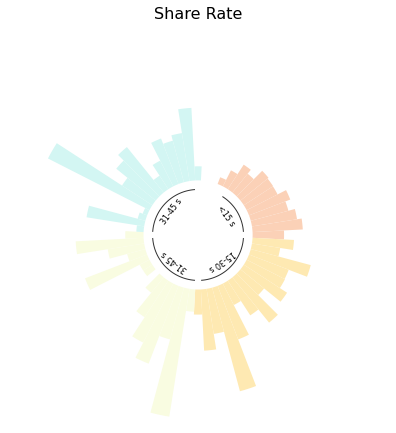

In [14]:
# Circular bar chart

# proprocess the data
import numpy as np
import matplotlib.pyplot as plt
# .sort_values(by='videoMeta.duration',axis=1)#.plot(kind="bar", legend=False)
count_df = df_clean[['videoMeta.duration']].groupby(
    df_clean["videoMeta.duration"]).count()
count_df = count_df.rename(columns={"videoMeta.duration": "count"})
count_df = count_df.reset_index()

avg_df = df_clean[['videoMeta.duration',
                   'likeRate', 'shareRate', 'commentRate']]
avg_df = avg_df.groupby(['videoMeta.duration'], as_index=False).agg(
    [np.mean]).reset_index()
avg_df.columns = avg_df.columns.droplevel(-1)
avg_df

# plot the data
fig = plt.figure(figsize=(16, 48), constrained_layout=True)


lower_limit = 0.003
ax1 = fig.add_subplot(131, projection='polar')
x = avg_df['videoMeta.duration']
y = avg_df["shareRate"]
ax1.set_theta_direction(-1)
ax1.set_xticks(np.arange(0, 2*np.pi, np.pi/2))
ax1.set_xticklabels(["60s", "15s", "30s", "45s"])
# ax1.set_ylim(0,0.012)
# ax1.yaxis.set_major_locator(plt.MultipleLocator(0.002))
ax1.set_theta_zero_location('N')
for _x, _y in zip(x, y):
    # _x = _x + np.pi/30
    _x_second = _x
    _x = _x*np.pi/30
    rotation = np.rad2deg(_x+np.pi/15+np.pi/30)
    print(_x, rotation)
    if _x <= np.pi/2:
        ax1.bar(x=_x, height=_y, width=np.pi/30,
                color='#FBD1B7', bottom=lower_limit)
    elif _x > np.pi/2 and _x <= np.pi:
        ax1.bar(x=_x, height=_y, width=np.pi/30,
                color='#FEE9B2', bottom=lower_limit)
    elif _x > np.pi and _x <= np.pi*3/2:
        ax1.bar(x=_x, height=_y, width=np.pi/30,
                color='#F9FCE1', bottom=lower_limit)
    else:
        ax1.bar(x=_x, height=_y, width=np.pi/30,
                color='#D3F6F3', bottom=lower_limit)
    # rotation = np.rad2deg(_x)     
    # if _x >= np.pi/2 and _x < 3*np.pi/2:
    #     alignment = "right"
    #     rotation = rotation + 180
    # else:
    #     alignment = "left"
    # print(_x,rotation)
    # ax1.text(
    #     x=_x,
    #     y=lower_limit + _y + 0.0005,
    #     s=f"{int(_x_second)} s",
    #     va='center',
    #     rotation=rotation,
    #     rotation_mode="anchor"
    # )

# draw the curve
# curve between 4s to 15s
x = np.linspace(np.pi/30+0.15*np.pi, np.pi/2 - np.pi/40, 100)
y = np.full(len(x), 0.0025)
ax1.plot(x, y, color='black', linewidth=1, alpha=0.8)  # draw the curve
# ax.text(x=np.pi/4, y=0.000774233508826262, s="<15s",ha="left", 
#         va='center', 
#         rotation=np.pi/4, 
#         rotation_mode="anchor")
ax1.text(x=np.pi/2-np.pi/12,y=0.002,s='<15 s',rotation=-54,rotation_mode='anchor',va='center',ha='right',size=8)
# # curve between 15s to 30s
x = np.linspace(np.pi/2 + np.pi/40, np.pi - np.pi/40, 100)
y = np.full(len(x), 0.0025)
ax1.plot(x, y, color='black', linewidth=1, alpha=0.8)  # draw the curve
ax1.text(x=np.pi-np.pi/10, y=0.002,s='15-30 s',rotation=-144,rotation_mode='anchor',va='center',ha='right',size=8)
# # curve between 30s to 45s
x = np.linspace(np.pi + np.pi/40, 3*np.pi/2-np.pi/40, 100)
y = np.full(len(x), 0.0025)
ax1.plot(x, y, color='black', linewidth=1, alpha=0.8)  # draw the curve
ax1.text(x=np.pi+ np.pi/10, y=0.002,s='31-45 s',rotation=144,rotation_mode='anchor',va='center',ha='left',size=8)
# # curve between 45s to 60s
x = np.linspace(3*np.pi/2+np.pi/40, 2*np.pi-np.pi/40, 100)
y = np.full(len(x), 0.0025)
ax1.plot(x, y, color='black', linewidth=1, alpha=0.8)  # draw the curve
ax1.text(x=3*np.pi/2+ np.pi/10, y=0.002,s='31-45 s',rotation=54,rotation_mode='anchor',va='center',ha='left',size=8)
# add title
ax1.set_title("Share Rate", fontsize=16)
plt.axis('off')
plt.show()


In [ ]:
ax1 = fig.add_subplot(131, projection='polar')
ax2 = fig.add_subplot(132, projection='polar')
def draw_circular_bar(ax, x, y, title,lower_limit):
    ax.set_theta_direction(-1)
    ax.set_xticks(np.arange(0, 2*np.pi, np.pi/2))
    ax.set_xticklabels(["60s", "15s", "30s", "45s"])
    ax.set_theta_zero_location('N')
    for _x, _y in zip(x, y):
        # _x = _x + np.pi/30
        _x_second = _x
        _x = _x*np.pi/30
        rotation = np.rad2deg(_x+np.pi/15+np.pi/30)
        if _x <= np.pi/2:
            ax.bar(x=_x, height=_y, width=np.pi/30,
                    color='#FBD1B7', bottom=lower_limit)
        elif _x > np.pi/2 and _x <= np.pi:
            ax.bar(x=_x, height=_y, width=np.pi/30,
                    color='#FEE9B2', bottom=lower_limit)
        elif _x > np.pi and _x <= np.pi*3/2:
            ax.bar(x=_x, height=_y, width=np.pi/30,
                    color='#F9FCE1', bottom=lower_limit)
        else:
            ax.bar(x=_x, height=_y, width=np.pi/30,
                    color='#D3F6F3', bottom=lower_limit)
    # draw the curve
    x = np.linspace(np.pi/30+0.15*np.pi, np.pi/2 - np.pi/40, 100)
    y = np.full(len(x), 0.0025)
    ax.plot(x, y, color='black', linewidth=1, alpha=0.8)  # draw the curve
    # ax.text(x=np.pi/4, y=0.000774233508826262, s="<15s",ha="left", 
    #         va='center', 
    #         rotation=np.pi/4, 
    #         rotation_mode="anchor")
    ax.text(x=np.pi/2-np.pi/12,y=0.002,s='<15 s',rotation=-54,rotation_mode='anchor',va='center',ha='right',size=8)
    # # curve between 15s to 30s
    x = np.linspace(np.pi/2 + np.pi/40, np.pi - np.pi/40, 100)
    y = np.full(len(x), 0.0025)
    ax.plot(x, y, color='black', linewidth=1, alpha=0.8)  # draw the curve
    ax.text(x=np.pi-np.pi/10, y=0.002,s='15-30 s',rotation=-144,rotation_mode='anchor',va='center',ha='right',size=8)
    # # curve between 30s to 45s
    x = np.linspace(np.pi + np.pi/40, 3*np.pi/2-np.pi/40, 100)
    y = np.full(len(x), 0.0025)
    ax.plot(x, y, color='black', linewidth=1, alpha=0.8)  # draw the curve
    ax.text(x=np.pi+ np.pi/10, y=0.002,s='31-45 s',rotation=144,rotation_mode='anchor',va='center',ha='left',size=8)
    # # curve between 45s to 60s
    x = np.linspace(3*np.pi/2+np.pi/40, 2*np.pi-np.pi/40, 100)
    y = np.full(len(x), 0.0025)
    ax.plot(x, y, color='black', linewidth=1, alpha=0.8)  # draw the curve
    ax.text(x=3*np.pi/2+ np.pi/10, y=0.002,s='31-45 s',rotation=54,rotation_mode='anchor',va='center',ha='left',size=8)
    # add title
    ax.set_title(title, fontsize=16)

ax2 = fig.add_subplot(132, projection='polar')
draw_circular_bar(ax1, x, y, "Share Rate",0.0025)
draw_circular_bar(ax2, avg_df["videoMeta.duration"], avg_df["likeRate"], "Like Rate", 0.0025)
plt.show()

In [ ]:
plt.show()